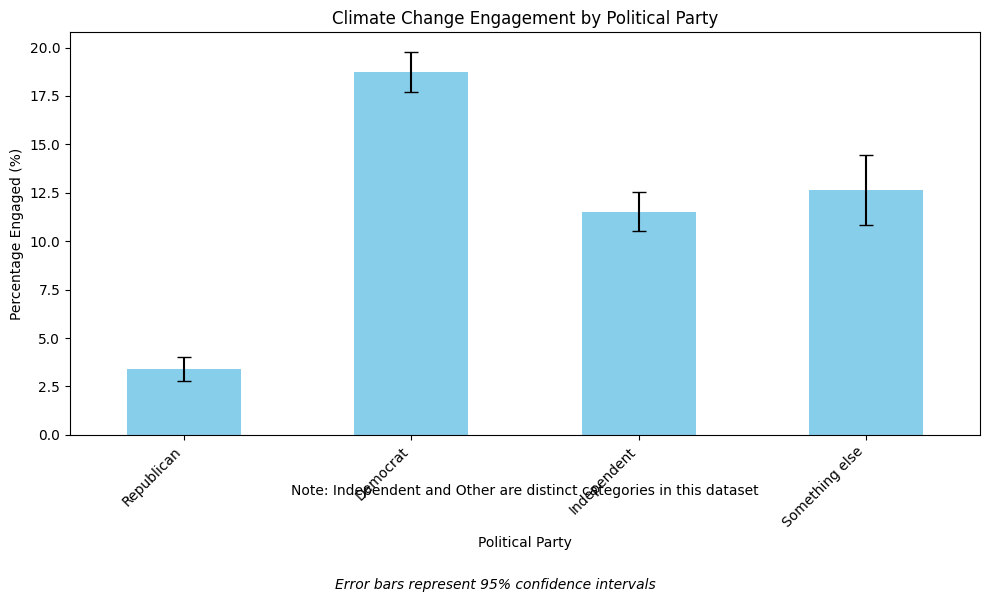

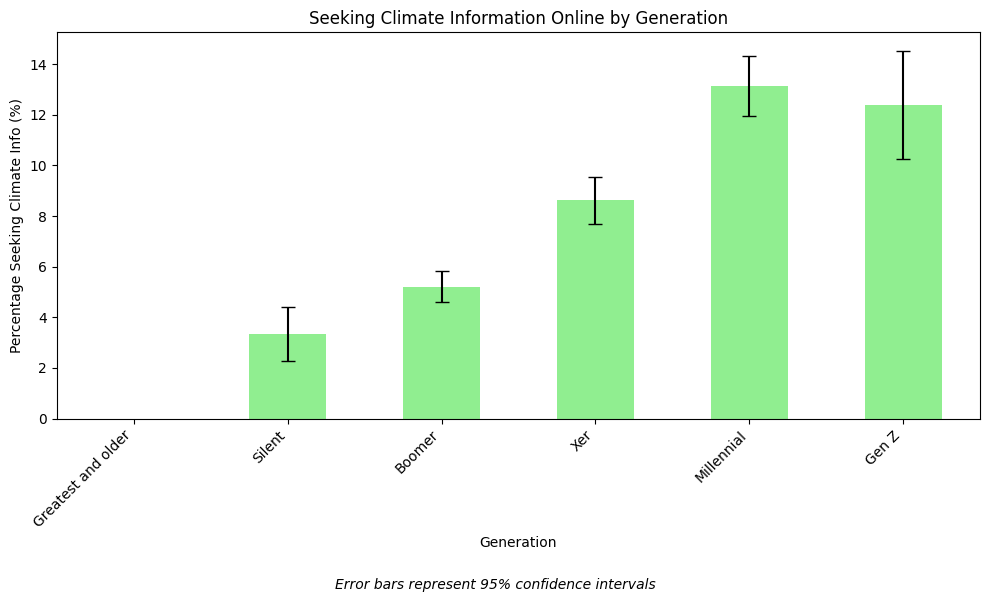

Engagement
0    12029
1     1720
Name: count, dtype: int64
(9624, 28) (9624,)
(16840, 28) (16840,)


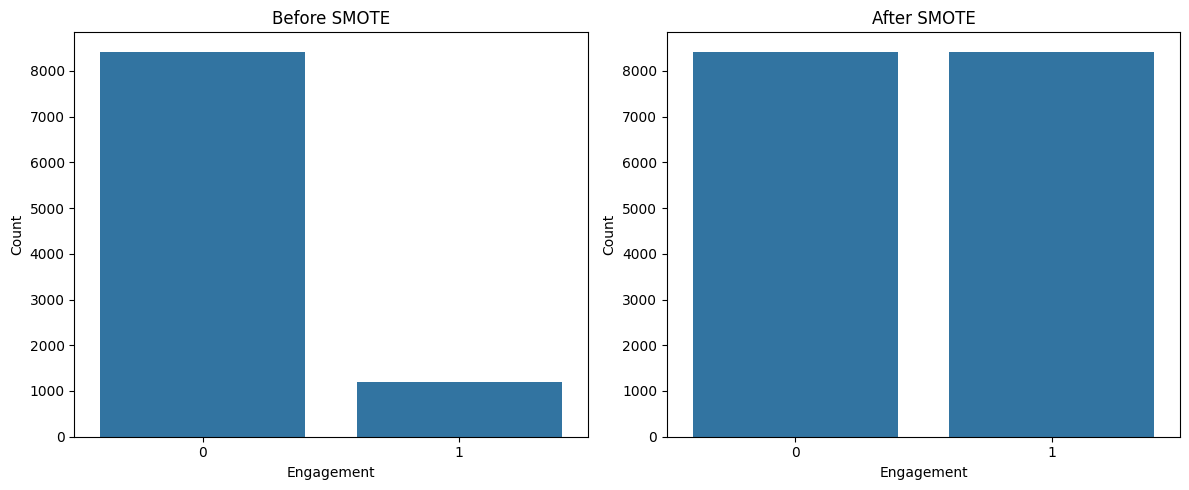

In [49]:
import pyreadstat
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the data
file_path = "ATP W89.sav"
df, meta = pyreadstat.read_sav(file_path)
# print(df.shape) # 164 columns

# initial filtering: drop clearly irrelevant
# keep columns with personal/demographic data, useful social media habits, target
df = df.drop(columns=["QKEY"])
interview_data = [x for x in df.columns if ("INTERVIEW" in x or "DEVICE" in x or "FORM" in x)]
df = df.drop(columns=interview_data)
# our target: how engaged individuals were
target = "ENGACTCT_W89"
# 2 features about social media habits selected from examining meaning in questionnaire/their metadata labels
sm_features = ["CLIMSEEK_W89","FOLCLIM_W89"]
# no longer need other questionnaire data, only using ENGACTCT to measure engagement, two social media habit cols relevant, personal data
personal_data = [x for x in df.columns if ("W89" not in x)]
keep_columns = personal_data + sm_features + [target]
df = df.loc[:,keep_columns]

# Create a dictionary for readable column names
# This addresses the formatting legends recommendation
column_mapping = {
    "F_CITIZEN": "Citizenship Status",
    "F_METRO": "Metropolitan Residence",
    "F_AGECAT": "Age Category",
    "F_SEX": "Gender",
    "F_RACETHN": "Race/Ethnicity",
    "F_EDUCCAT": "Education Level",
    "F_CREGION": "Census Region",
    "F_MARITAL": "Marital Status",
    "F_INC_CAT": "Income Category",
    "F_PARTY_FINAL": "Political Party",
    "F_CHHISP": "Hispanic Heritage",
    "F_REGICDT": "Voter Registration",
    "F_GENERATIONS": "Generation",
    "F_REG": "Region",
    "F_PARTYLN_FINAL": "Party Leaning",
    "F_ATTEND": "Religious Service Attendance",
    "F_BORN": "US Born",
    "F_RELIG": "Religious Affiliation",
    "F_RELIGCAT": "Religion Category",
    "F_RELIGPROT": "Protestant Denomination",
    "F_RELIGCATH": "Catholic Denomination",
    "F_RELIG_FINAL": "Final Religious Identity",
    "F_RELIGCAT1": "Religion Category 1",
    "F_INC_TIER2": "Income Tier 2",
    "CLIMSEEK_W89": "Seeks Climate Info Online",
    "FOLCLIM_W89": "Follows Climate Accounts",
    "ENGACTCT_W89": "Climate Engagement"
}

def get_feat_vals_labels(column):
    print(df[column].value_counts())
    print(meta.variable_value_labels.get(column))

def get_na_columns():
    na_counts = pd.DataFrame({"na":df.isna().apply(sum)})
    na_columns = na_counts.loc[na_counts["na"]>0]
    return na_columns

# na_columns = get_na_columns()
# for col in na_columns.index:
#     get_feat_vals_labels(col)
df = df.drop(columns=["F_BORN","F_PARTYLN_FINAL"]) # dropped these columns b/c high proportion of NaNs & exist at least 1 other complete col describing similar data

# impute missing vals and 99.0s ('Refused') with mode
na_cols = get_na_columns().index
for i in range(len(df.columns)):
    column = df.columns[i]
    col_mode = df[column].mode()[0]
    if(column in na_cols):
        df[column] = df[column].fillna(col_mode)
    df[column] = df[column].apply(lambda x: col_mode if x==99.0 else x) # treat 99.0 ("Refused") as missing val

# Also want to recode the target feature -> target column name, values more interpretable:
df = df.rename(columns={"ENGACTCT_W89":"Engagement"})
df["Engagement"] = df["Engagement"].apply(lambda x: 1 if x>=2.0 else 0) # 1 represents active/engaged, 0 not

# EDA Question 1: How does engagement differ by political party?
plt.figure(figsize=(10, 6))
party_engage = df.groupby(['F_PARTY_FINAL', 'Engagement']).size().unstack()
party_engage_pct = party_engage.div(party_engage.sum(axis=1), axis=0) * 100

# Add error bars for 95% confidence interval
party_counts = df.groupby('F_PARTY_FINAL').size()
conf_intervals = []
for party in party_engage_pct.index:
    n = party_counts[party]
    p = party_engage_pct.loc[party, 1] / 100
    # 95% confidence interval for proportion
    margin = 1.96 * np.sqrt((p * (1-p)) / n)
    conf_intervals.append(margin * 100)  # Convert to percentage

ax = party_engage_pct[1].plot(kind='bar', yerr=conf_intervals, capsize=5, color='skyblue')
plt.title('Climate Change Engagement by Political Party')
plt.xlabel('Political Party')
plt.ylabel('Percentage Engaged (%)')

# Replace numeric labels with readable ones using the meta information
party_labels = meta.variable_value_labels.get('F_PARTY_FINAL')
if party_labels:
    party_names = [party_labels.get(code, str(code)) for code in party_engage_pct.index]
    ax.set_xticklabels(party_names, rotation=45, ha='right')

# Add note about error bars
plt.figtext(0.5, 0.01, 'Error bars represent 95% confidence intervals', 
            ha='center', fontsize=10, style='italic')

# Note: Check if 'Other' and 'Independent' are the same in your dataset
plt.annotate('Note: Independent and Other are distinct categories in this dataset',
             xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# EDA Question 2: How does social media climate content seeking behavior vary by generation?
plt.figure(figsize=(10, 6))
gen_climate = df.groupby(['F_GENERATIONS', 'CLIMSEEK_W89']).size().unstack()
gen_climate_pct = gen_climate.div(gen_climate.sum(axis=1), axis=0) * 100

# Add error bars for 95% confidence interval
gen_counts = df.groupby('F_GENERATIONS').size()
conf_intervals = []
for gen in gen_climate_pct.index:
    n = gen_counts[gen]
    p = gen_climate_pct.loc[gen, 1] / 100 if 1 in gen_climate_pct.columns else 0
    # 95% confidence interval for proportion
    margin = 1.96 * np.sqrt((p * (1-p)) / n)
    conf_intervals.append(margin * 100)  # Convert to percentage

ax = gen_climate_pct[1].plot(kind='bar', yerr=conf_intervals, capsize=5, color='lightgreen')
plt.title('Seeking Climate Information Online by Generation')
plt.xlabel('Generation')
plt.ylabel('Percentage Seeking Climate Info (%)')

# Replace numeric labels with readable ones using the meta information
gen_labels = meta.variable_value_labels.get('F_GENERATIONS')
if gen_labels:
    gen_names = [gen_labels.get(code, str(code)) for code in gen_climate_pct.index]
    ax.set_xticklabels(gen_names, rotation=45, ha='right')

# Add note about error bars
plt.figtext(0.5, 0.01, 'Error bars represent 95% confidence intervals', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# Check for imbalances
print(df["Engagement"].value_counts()) # need to resample

# create train-test splits before resampling
target = df["Engagement"]
feat_df = df.drop(columns=["Engagement"])
X_train, X_test, y_train, y_test = train_test_split(
    feat_df, target, test_size=0.3, random_state=42, stratify=target
)

# run SMOTE
smote = SMOTE(random_state=3001)
print(X_train.shape,y_train.shape)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train,y_train)
print(X_train_balanced.shape,y_train_balanced.shape) # fix oversampling, then remember the recoding of target into >2, <=2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Engagement")
axes[0].set_ylabel("Count")

# Plot after SMOTE
sns.countplot(x=y_train_balanced, ax=axes[1])
axes[1].set_title("After SMOTE")
axes[1].set_xlabel("Engagement")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
# Ready for PCA: missing vals addressed, all cols encoded, no need to scale b/c encoding addresses scale (e.g. income ranges instead of raw incomes), sampling done for imbalance


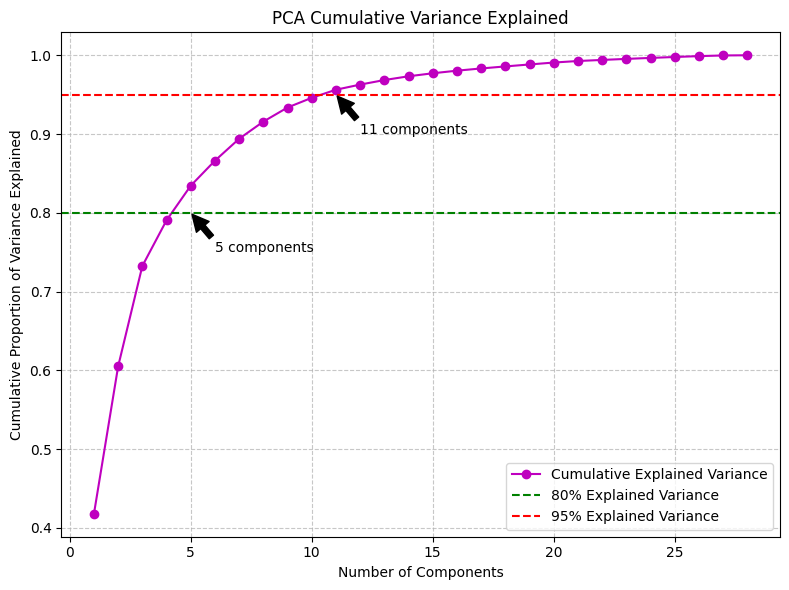

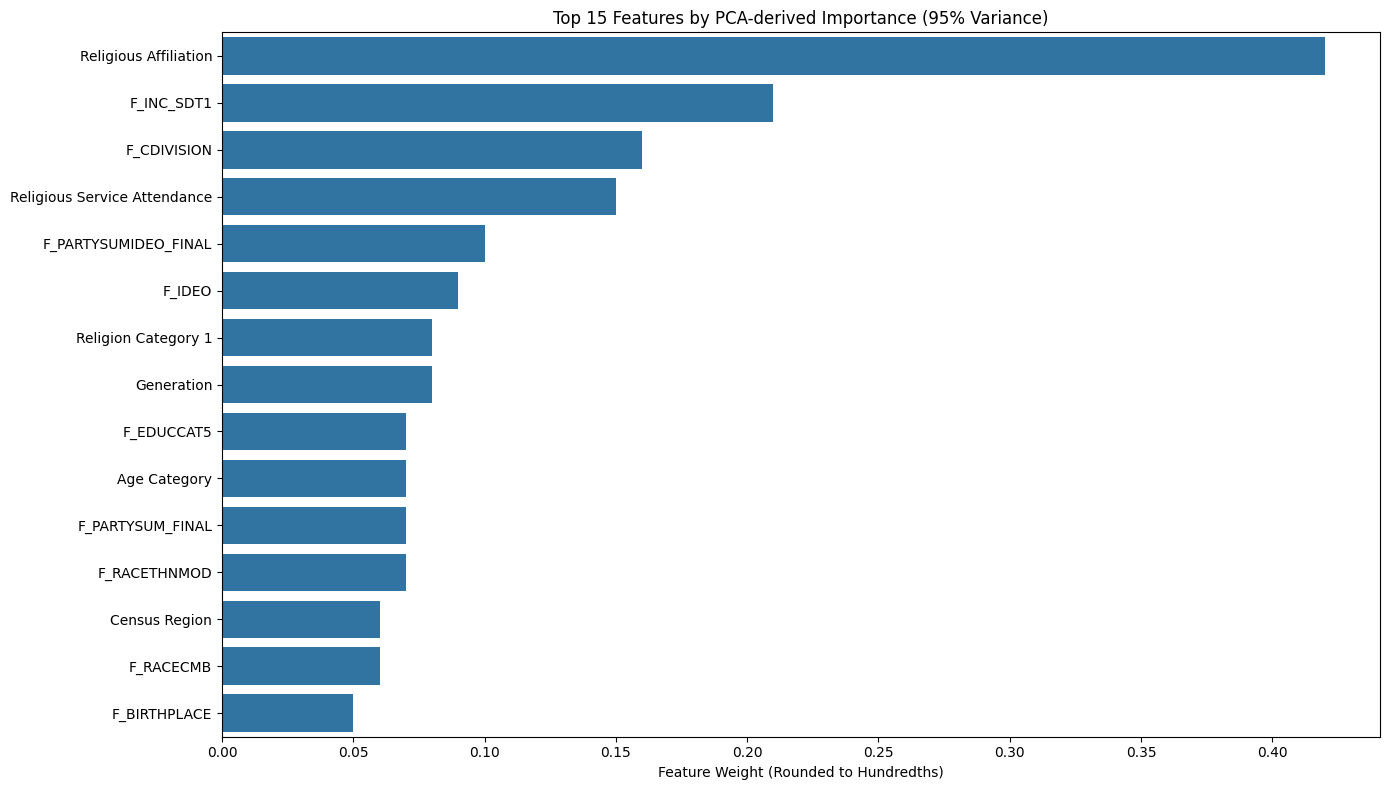

In [50]:
# PCA Analysis:
# Number of components to try
pca = PCA()
pca.fit(X_train_balanced)

# Plot cumulative explained variance - addressing the professor's recommendation
plt.figure(figsize=[8, 6])
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='-', color='m', 
         label='Cumulative Explained Variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Proportion of Variance Explained")
plt.title("PCA Cumulative Variance Explained")
plt.grid(True, linestyle='--', alpha=0.7)

# Add horizontal lines for common thresholds
plt.axhline(y=0.8, color='g', linestyle='--', label="80% Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")

# Find and annotate the number of components for thresholds
n_components_80 = np.where(cum_var >= 0.8)[0][0] + 1
n_components_95 = np.where(cum_var >= 0.95)[0][0] + 1
plt.annotate(f'{n_components_80} components', 
             xy=(n_components_80, 0.8), 
             xytext=(n_components_80+1, 0.75),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'{n_components_95} components', 
             xy=(n_components_95, 0.95), 
             xytext=(n_components_95+1, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.tight_layout()
plt.show()

# Perform PCA with the number of components needed for 95% variance
pca = PCA(n_components=n_components_95)
pca.fit(X_train_balanced)

# Calculate feature importance from PCA
feature_weights = np.zeros(len(X_train_balanced.columns))
for i in range(n_components_95):
    component = np.abs(pca.components_[i])
    var_ratio = pca.explained_variance_ratio_[i]
    feature_weights += component * var_ratio

# Create DataFrame with readable feature names
feature_importance = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Readable_Name': [column_mapping.get(col, col) for col in X_train_balanced.columns],
    'Weight': feature_weights
})

feature_importance = feature_importance.sort_values('Weight', ascending=False)
feature_importance['Weight_Rounded'] = feature_importance['Weight'].round(2)

# Plot feature importance with readable names
plt.figure(figsize=(14, 8))
sns.barplot(x='Weight_Rounded', y='Readable_Name', data=feature_importance.head(15))
plt.title('Top 15 Features by PCA-derived Importance (95% Variance)')
plt.xlabel('Feature Weight (Rounded to Hundredths)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Reduce dimensionality based on cumulative importance derived from PCA
# drop lowest-weight repeat feats ("F_RELIGCAT1", "F_INC_TIER2"), other lowest-weight (F_metro,F_citizen,F_reg,F_Cregion)
X_train_balanced = X_train_balanced.drop(columns=["F_RELIGCAT1","F_INC_TIER2","F_METRO","F_CITIZEN","F_REG","F_CREGION"], errors='ignore')
X_test = X_test.drop(columns=["F_RELIGCAT1","F_INC_TIER2","F_METRO","F_CITIZEN","F_REG","F_CREGION"], errors='ignore')


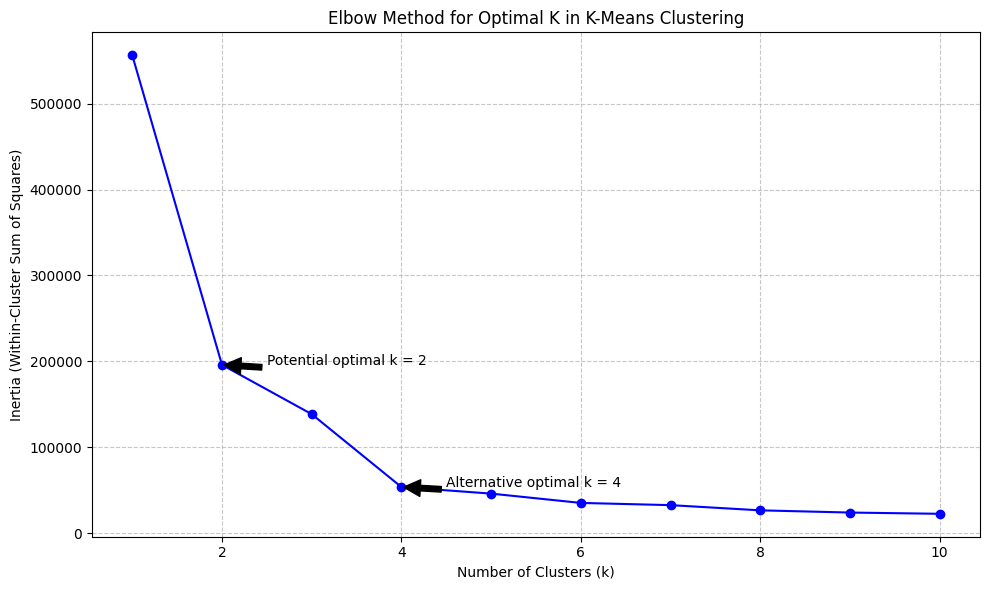


Cluster Characteristics (Mean Values):
Cluster                          0      1
F_CDIVISION                   5.09   5.46
Age Category                  2.72   2.47
F_GENDER                      1.60   1.56
Education Level               1.57   1.46
F_EDUCCAT5                    3.67   3.83
F_HISP                        1.82   1.87
F_YEARSINUS                   1.30   1.27
F_RACECMB                     1.40   1.42
F_RACETHNMOD                  1.61   1.61
F_BIRTHPLACE                  1.37   1.33
Religious Affiliation         1.62  10.70
Religious Service Attendance  3.42   5.42
Political Party               2.16   2.47
F_PARTYSUM_FINAL              1.77   2.01
F_PARTYSUMIDEO_FINAL          2.80   3.61
F_INC_SDT1                    5.51   5.54
F_IDEO                        2.95   3.84
F_INTFREQ                     1.67   1.53
F_VOLSUM                      1.46   1.50
Generation                    3.78   4.07
Seeks Climate Info Online     1.88   1.85
Follows Climate Accounts      1.76  

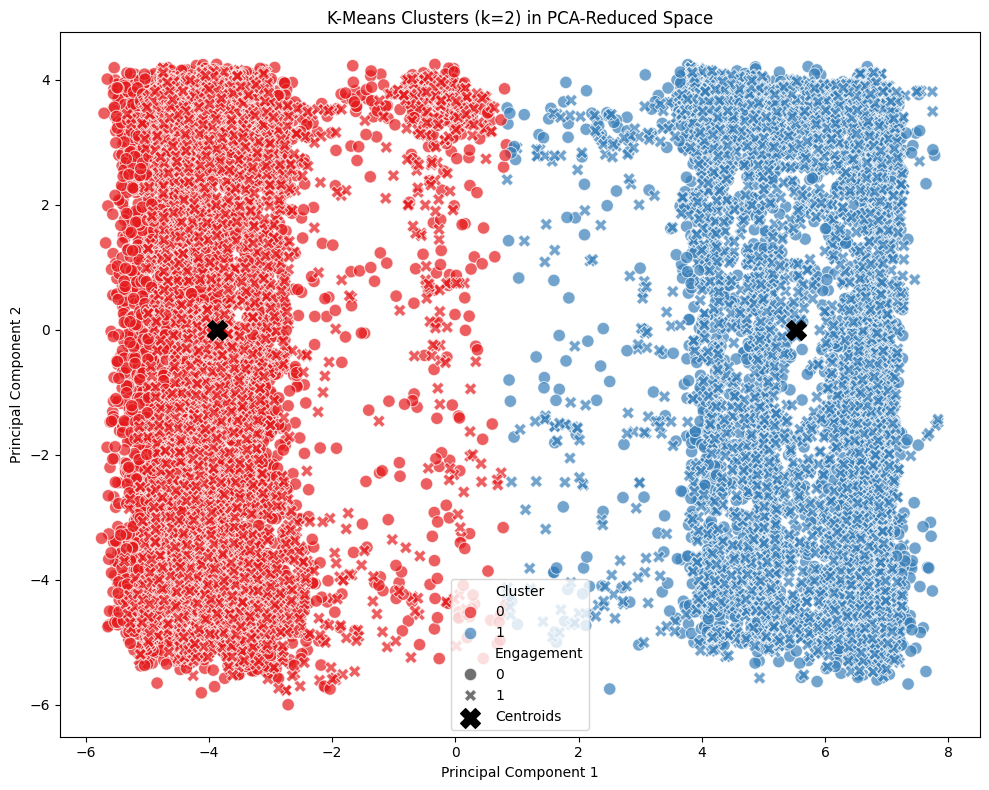

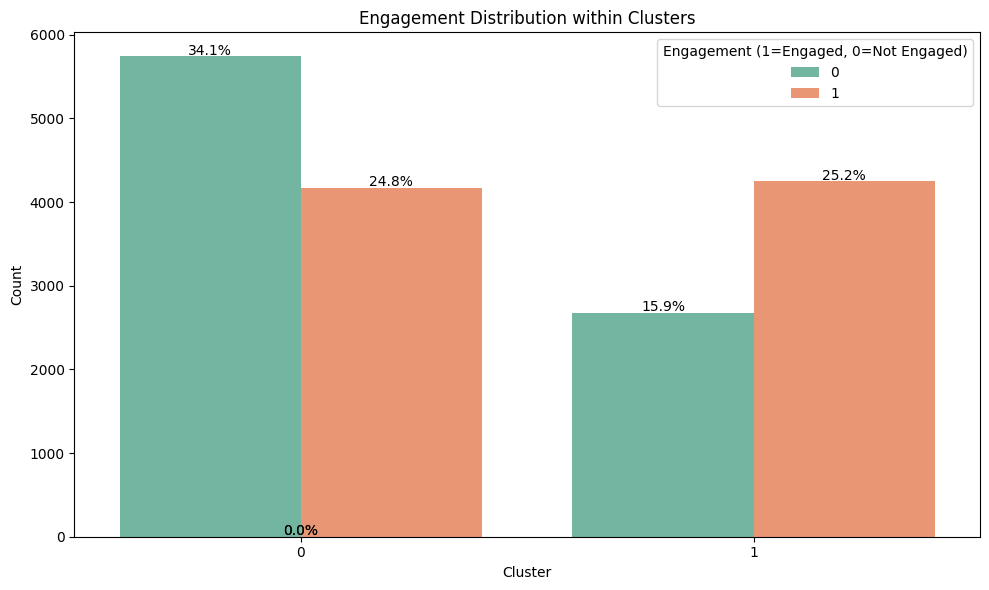

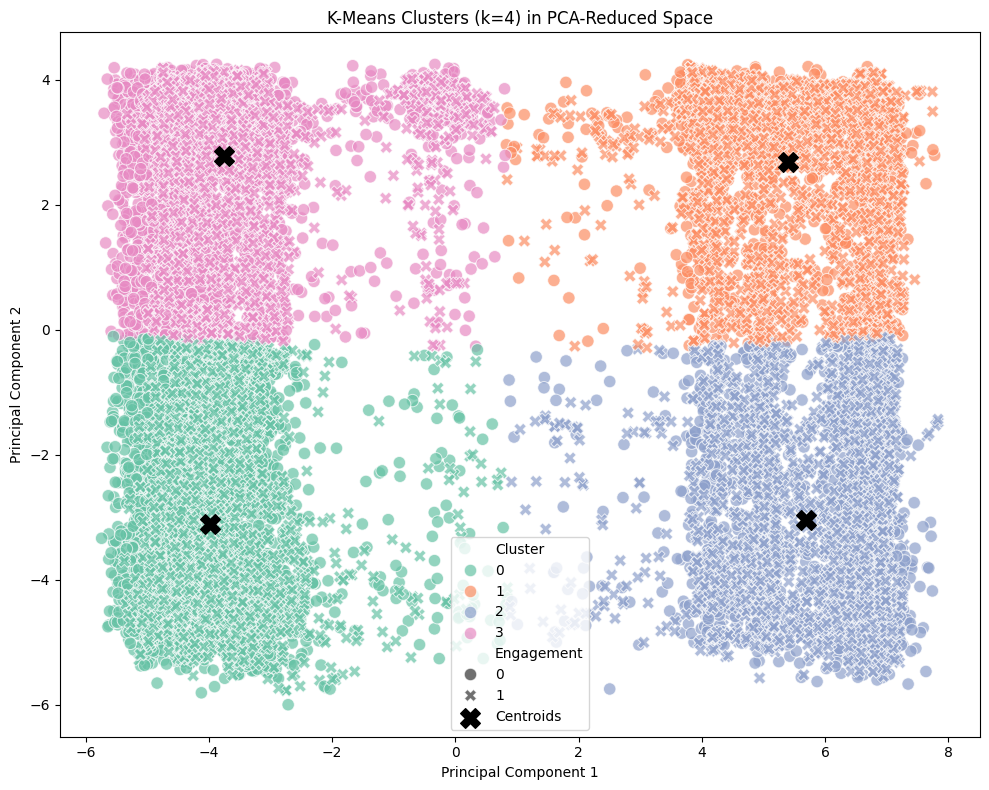

In [51]:
# K-means clustering
# Using to see patterns in social media behavior that might not directly relate to climate engagement labels

# PCA for dimensionality reduction to 2D for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_balanced)

# Elbow plot to determine optimal number of clusters
inertia = []
k_vals = range(1, 11)  # Expanded range to see more of the elbow curve
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca_2d)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_vals, inertia, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K in K-Means Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations for potential optimal k values
plt.annotate('Potential optimal k = 2', 
             xy=(2, inertia[1]), 
             xytext=(2.5, inertia[1]+300),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Alternative optimal k = 4', 
             xy=(4, inertia[3]), 
             xytext=(4.5, inertia[3]+500),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

# Using k=2 based on elbow plot and other trials with different k-values
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_2d)

# Create table of cluster means for interpretation
clustered_df = X_train_balanced.copy()
clustered_df["Cluster"] = clusters
cluster_means = clustered_df.groupby("Cluster").mean()

# Format the cluster means table with readable column names
readable_cluster_means = cluster_means.copy()
readable_cluster_means.columns = [column_mapping.get(col, col) for col in readable_cluster_means.columns]
print("\nCluster Characteristics (Mean Values):")
print(readable_cluster_means.round(2).T)

# Create PCA visualization of clusters
pca_df = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters
pca_df["Engagement"] = y_train_balanced.reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", style="Engagement", s=80, alpha=0.7)
plt.title("K-Means Clusters (k=2) in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")

# Add centroids to the plot
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='X', c='black', label='Centroids')
plt.legend()
plt.tight_layout()
plt.show()

# Create table showing correlation between clusters and engagement
correlation = pca_df["Cluster"].corr(pca_df["Engagement"])
correlation_df = pd.DataFrame({
    'Metric': ['Correlation between clusters and engagement'],
    'Value': [round(correlation, 3)]
})

# Distribution of engagement within clusters
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=pca_df, x="Cluster", hue="Engagement", palette="Set2")
plt.title("Engagement Distribution within Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Engagement (1=Engaged, 0=Not Engaged)", loc="best")

# Add percentages above bars
total = len(pca_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2., height + 20, percentage, ha="center") 

plt.tight_layout()
plt.show()

# Run PCA with 4 components (alternative optimal k) for comparison
plt.figure(figsize=(10, 8))
kmeans4 = KMeans(n_clusters=4, random_state=42)
clusters4 = kmeans4.fit_predict(X_pca_2d)
pca_df4 = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
pca_df4["Cluster"] = clusters4
pca_df4["Engagement"] = y_train_balanced.reset_index(drop=True)

sns.scatterplot(data=pca_df4, x="PC1", y="PC2", hue="Cluster", palette="Set2", style="Engagement", s=80, alpha=0.7)
plt.title("K-Means Clusters (k=4) in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")

# Add centroids to the plot
centroids4 = kmeans4.cluster_centers_
plt.scatter(centroids4[:, 0], centroids4[:, 1], s=200, marker='X', c='black', label='Centroids')
plt.legend()
plt.tight_layout()
plt.show()

Cluster 0:
Slightly older

Slightly more liberal

Less religious

A bit more likely to follow climate orgs


Cluster 1:
Younger

More conservative

Significantly more religious (possibly weekly churchgoers)

Slightly higher education

Slightly less climate engagement

Decision Tree Best Estimator Parameter Values (GridSearch)
   max_depth  min_samples_split  min_samples_leaf
0      None                 10                 4
Random Forest Best Estimator Parameter Values (GridSearch)
    n_estimators max_depth  min_samples_split  min_samples_leaf
0           100      None                  5                 1
Decision Tree
Accuracy: 0.8363636363636363
F1 Score (macro): 0.5827382084346563
F1 Score (weighted): 0.8266634101088899
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      3609
           1       0.30      0.23      0.26       516

    accuracy                           0.84      4125
   macro avg       0.60      0.58      0.58      4125
weighted avg       0.82      0.84      0.83      4125



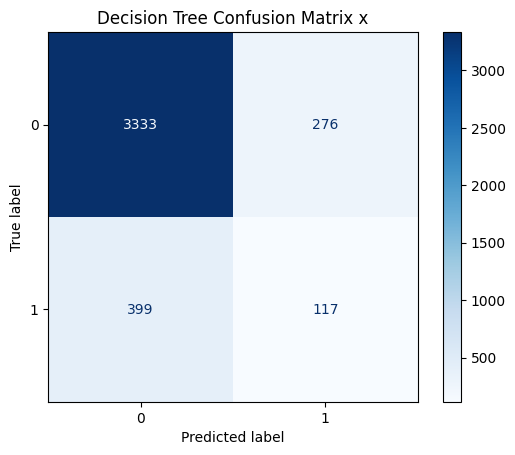

Random Forest (custom threshold)
Accuracy: 0.8487272727272728
F1 Score (macro): 0.6443521350478121
F1 Score (weighted): 0.8465050934240742
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      3609
           1       0.39      0.36      0.37       516

    accuracy                           0.85      4125
   macro avg       0.65      0.64      0.64      4125
weighted avg       0.84      0.85      0.85      4125



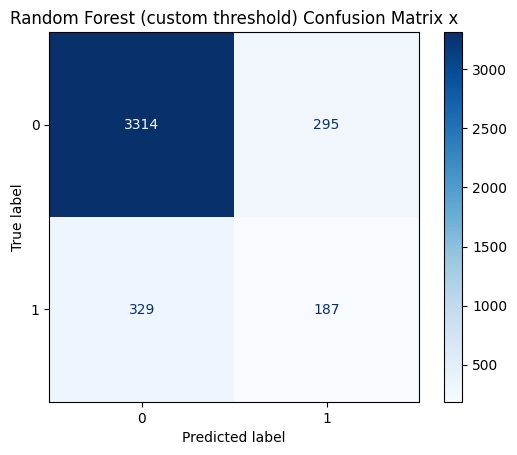

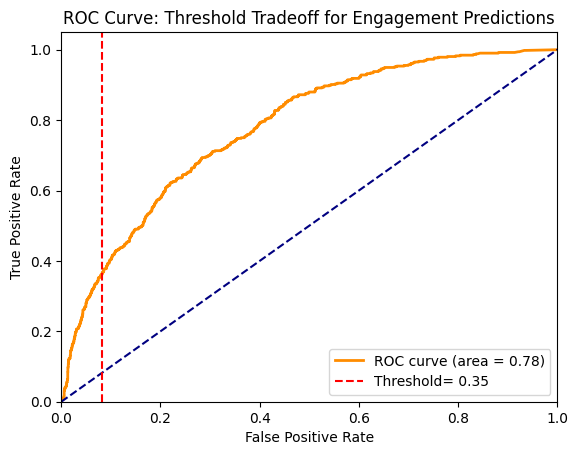

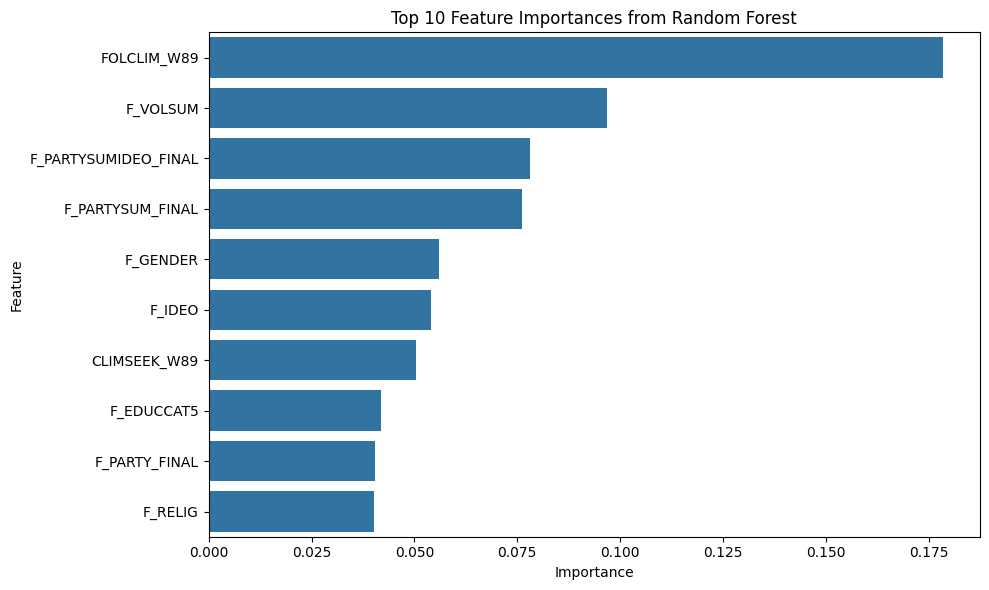

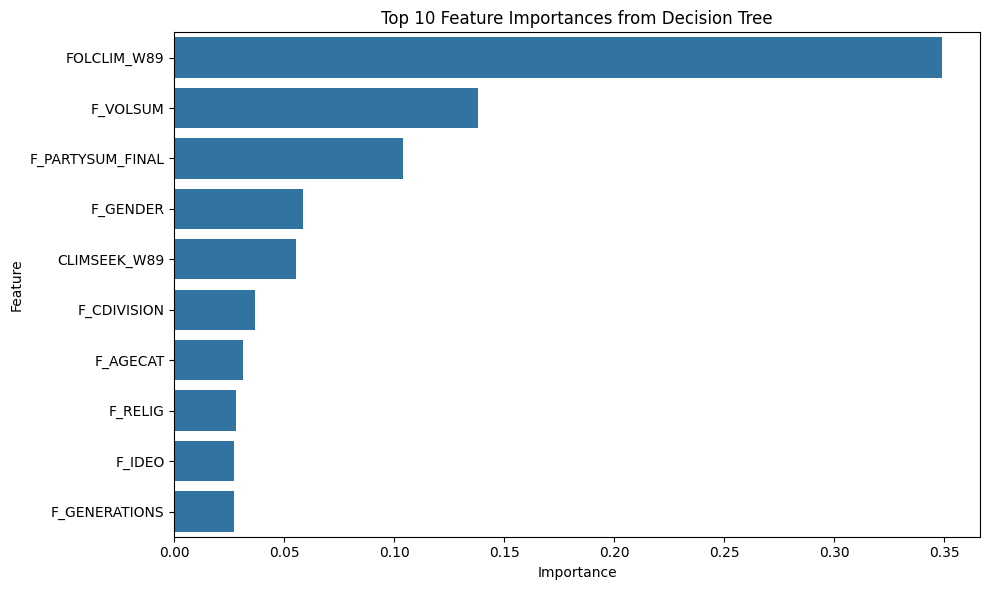

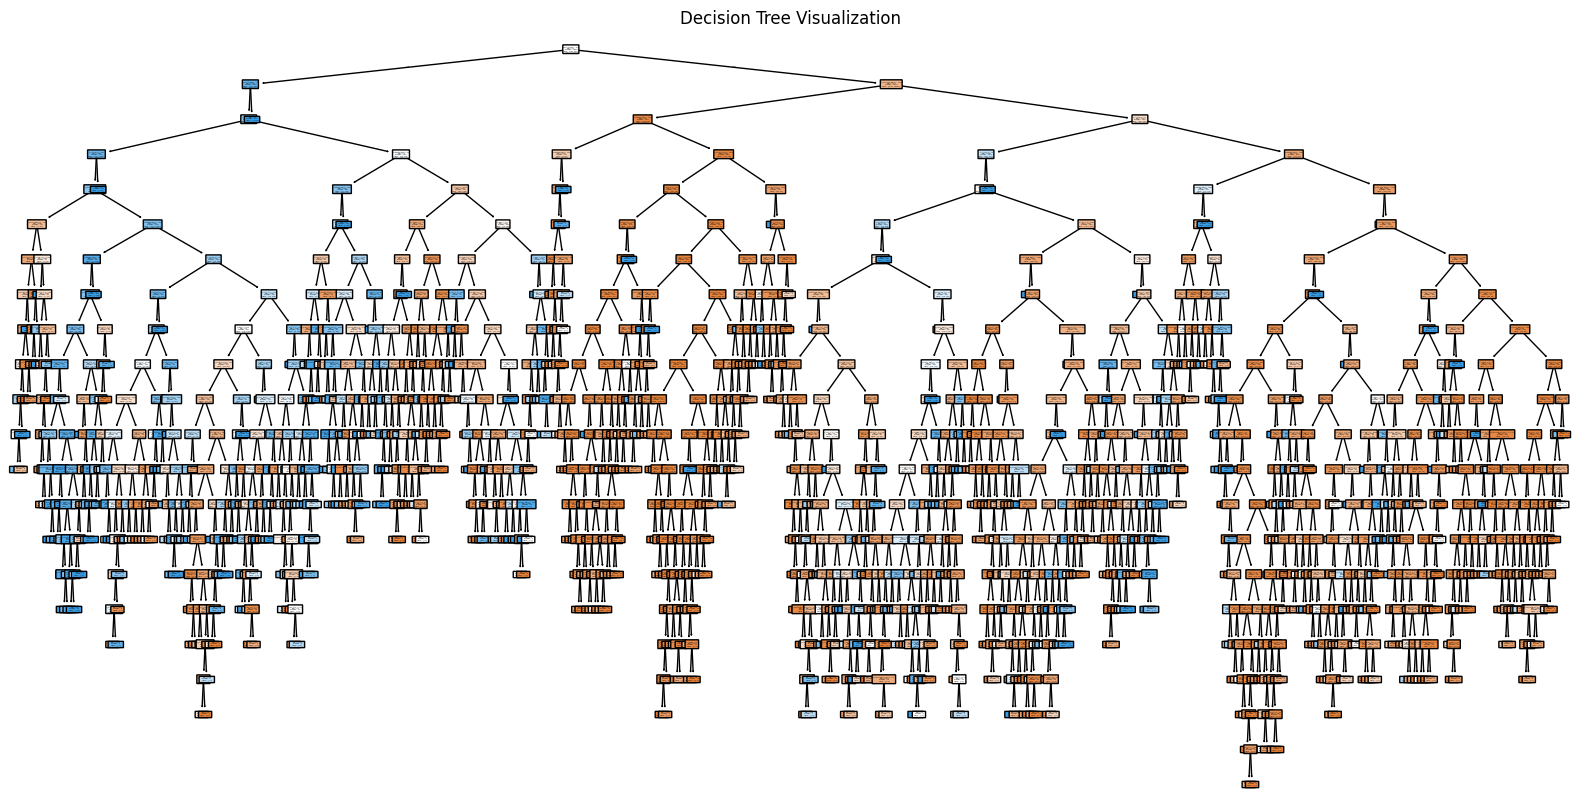

In [53]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#changes made during tuning to get better results in the takes action group are shown through comments w/ old version and explination of change made 
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# dt = DecisionTreeClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')  # Added class weighting to improve model for takes action group

# dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_weighted')
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1_macro')  # Changed scoring to focus on balanced performance

dt_grid.fit(X_train_balanced, y_train_balanced)
dt_best = dt_grid.best_estimator_
dt_arr_params = dt_best.get_params()
dt_params = pd.DataFrame({"max_depth":dt_arr_params["max_depth"],"min_samples_split":dt_arr_params["min_samples_split"],"min_samples_leaf":dt_arr_params["min_samples_leaf"]},index=[0])
print("Decision Tree Best Estimator Parameter Values (GridSearch)\n",dt_params)
y_pred_dt = dt_best.predict(X_test)


rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# rf = RandomForestClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')  # Added class weighting

# rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_weighted')
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1_macro')  # Changed scoring to macro F1 so that the model might better focus on the takes action group as well as the no action group even though we did already balance them through SMOTE

rf_grid.fit(X_train_balanced, y_train_balanced)
rf_best = rf_grid.best_estimator_
rf_arr_params = rf_best.get_params()
rf_params = pd.DataFrame({"n_estimators":rf_arr_params["n_estimators"],"max_depth":rf_arr_params["max_depth"],"min_samples_split":rf_arr_params["min_samples_split"],"min_samples_leaf":rf_arr_params["min_samples_leaf"]},index=[0])
print("Random Forest Best Estimator Parameter Values (GridSearch)\n",rf_params)

# y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]  # Use probabilities to apply custom threshold
threshold = 0.35  # Lower threshold to boost recall for class 1 so that classification of what counts as engaged isn't too strict
y_pred_rf = (y_proba_rf >= threshold).astype(int)

def evaluate_model(name, y_test, y_pred):
    print(name)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
    print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix x")
    plt.show()

evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Random Forest (custom threshold)", y_test, y_pred_rf)

# ROC curve to evaluate TPR/FPR tradeoff:
def plotROC(check_threshold):
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
    roc_auc = auc(fpr,tpr)
    threshold_index = np.argmin(np.abs(thresholds-check_threshold)) # asked chatGPT how to find closest matching val in arr
    fpr_threshold = fpr[threshold_index]

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axvline(x=fpr_threshold, color='r',linestyle='--',label=f'Threshold= {check_threshold:.2f}')  # asked chatGPT how to plot vertical line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Threshold Tradeoff for Engagement Predictions')
    plt.legend(loc="lower right")
    plt.show()

plotROC(0.35) # adjusted rf above based on tested thresholds

# Random Forest feature importances
importances_rf = rf_best.feature_importances_
feat_names = X_train_balanced.columns
importance_df_rf = pd.DataFrame({'Feature': feat_names, 'Importance': importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_rf.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Decision Tree feature importances
importances_dt = dt_best.feature_importances_
importance_df_dt = pd.DataFrame({'Feature': feat_names, 'Importance': importances_dt})
importance_df_dt = importance_df_dt.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df_dt.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances from Decision Tree")
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(
    dt_best,
    feature_names=feat_names,
    class_names=["No Action", "Takes Action"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()
